<a href="https://colab.research.google.com/github/om7503/Multiple-diseases-prediction-System/blob/main/HeartFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Load the heart disease dataset
heart_data = pd.read_csv('/content/heart.csv')

# Splitting the features and target
X = heart_data.drop(columns='target', axis=1)  # Features
Y = heart_data['target']  # Target

# Check for class imbalance
print("Class distribution before SMOTE:")
print(Y.value_counts())

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_resampled, test_size=0.2, stratify=Y_resampled, random_state=42)

# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVC': SVC(probability=True, random_state=42),  # Support Vector Classifier
    'KNN': KNeighborsClassifier()  # K-Nearest Neighbors
}

# Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                       param_distributions=param_dist_rf,
                                       n_iter=10,  # Number of parameter settings to sample
                                       cv=5,
                                       scoring='accuracy',
                                       n_jobs=-1,
                                       random_state=42)

random_search_rf.fit(X_train, Y_train)

# Best model from random search
best_rf_model = random_search_rf.best_estimator_
print(f'Best Random Forest Model: {best_rf_model}')

# Evaluate the best Random Forest model
rf_predictions = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(Y_test, rf_predictions)
print(f'Best Random Forest Accuracy: {rf_accuracy}')

# Stacking models with VotingClassifier
stacking_model = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')

# Fit the stacking model
stacking_model.fit(X_train, Y_train)

# Evaluate stacking model
stacking_predictions = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(Y_test, stacking_predictions)
print('Stacking Classifier Accuracy: ', stacking_accuracy)

# Check accuracy for each model and cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    # Cross-validation
    scores = cross_val_score(model, X_scaled, Y_resampled, cv=cv, scoring='accuracy')
    print(f'{name} CV Accuracy: {scores.mean()}')

    # Fit and evaluate model
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(Y_test, predictions)
    print(f'{name} Accuracy: {accuracy}')

# Store the best model based on accuracy
best_model_name = max([(stacking_accuracy, 'Stacking Classifier')] +
                      [(accuracy_score(Y_test, model.predict(X_test)), name) for name, model in models.items()],
                      key=lambda x: x[0])

print(f'Best Model: {best_model_name[1]} with accuracy of {best_model_name[0]}')

# Confusion matrix and classification report for the best model
print("\nConfusion Matrix for the Best Model:")
print(confusion_matrix(Y_test, stacking_predictions))
print("\nClassification Report for the Best Model:")
print(classification_report(Y_test, stacking_predictions))


Class distribution before SMOTE:
target
1    165
0    138
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Forest Model: RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)
Best Random Forest Accuracy: 0.8333333333333334


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacking Classifier Accuracy:  0.8484848484848485
Random Forest CV Accuracy: 0.8272727272727272
Random Forest Accuracy: 0.8181818181818182
Gradient Boosting CV Accuracy: 0.8303030303030303
Gradient Boosting Accuracy: 0.8484848484848485


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost CV Accuracy: 0.8272727272727274
XGBoost Accuracy: 0.8636363636363636
SVC CV Accuracy: 0.8333333333333334
SVC Accuracy: 0.8484848484848485


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KNN CV Accuracy: 0.806060606060606
KNN Accuracy: 0.8484848484848485
Best Model: XGBoost with accuracy of 0.8636363636363636

Confusion Matrix for the Best Model:
[[27  6]
 [ 4 29]]

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        33
           1       0.83      0.88      0.85        33

    accuracy                           0.85        66
   macro avg       0.85      0.85      0.85        66
weighted avg       0.85      0.85      0.85        66



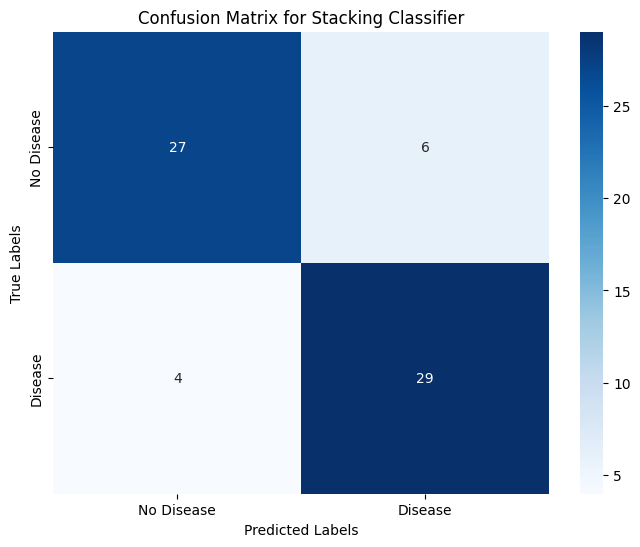

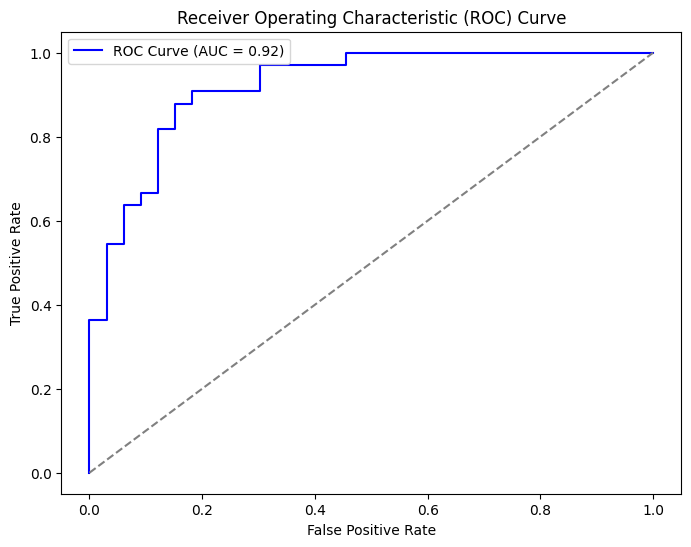

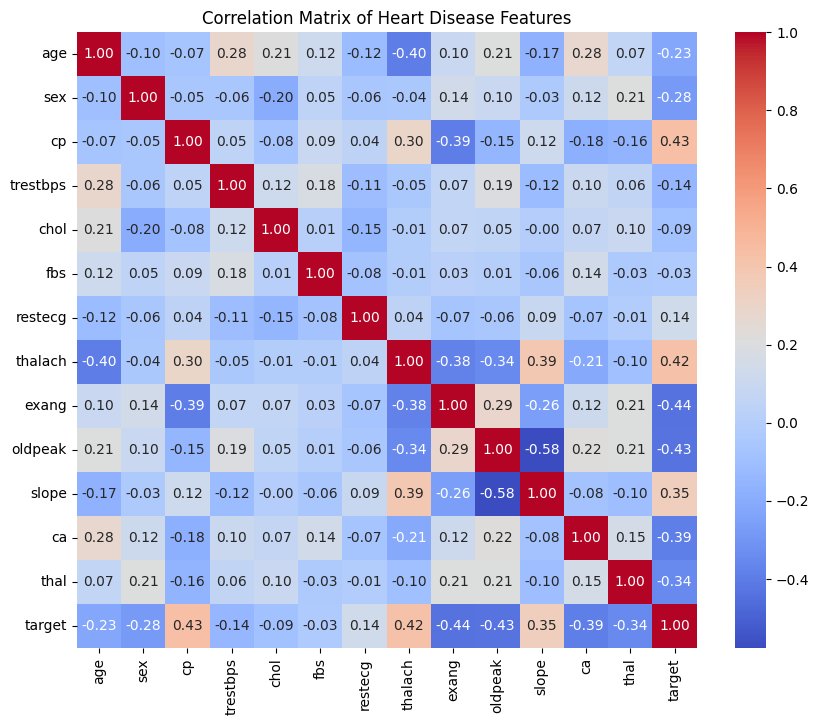

In [ ]:
# Import necessary libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# --- Confusion Matrix for Stacking Classifier ---
conf_matrix = confusion_matrix(Y_test, stacking_predictions)

# Visualize the confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix for Stacking Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- ROC Curve for Stacking Classifier ---
# Get the probability scores for the test data
stacking_probs = stacking_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(Y_test, stacking_probs)
roc_auc = roc_auc_score(Y_test, stacking_probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(10, 8))
correlation = heart_data.corr()  # Calculate the correlation matrix
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Heart Disease Features')
plt.show()
